# 順序尺度の相関係数

アンケート調査の「1: あてはまらない」「2: どちらともいえない」「3: あてはまる」のような3値をとる順序尺度の変数や、「該当する」「該当しない」のような二値変数のような、値の種類数が比較的少ない順序尺度の相関係数は、ピアソンの積率相関係数で測った場合過小評価される（絶対値が小さくなる傾向がある）。これは**相関係数の希薄化**と呼ばれる現象である。


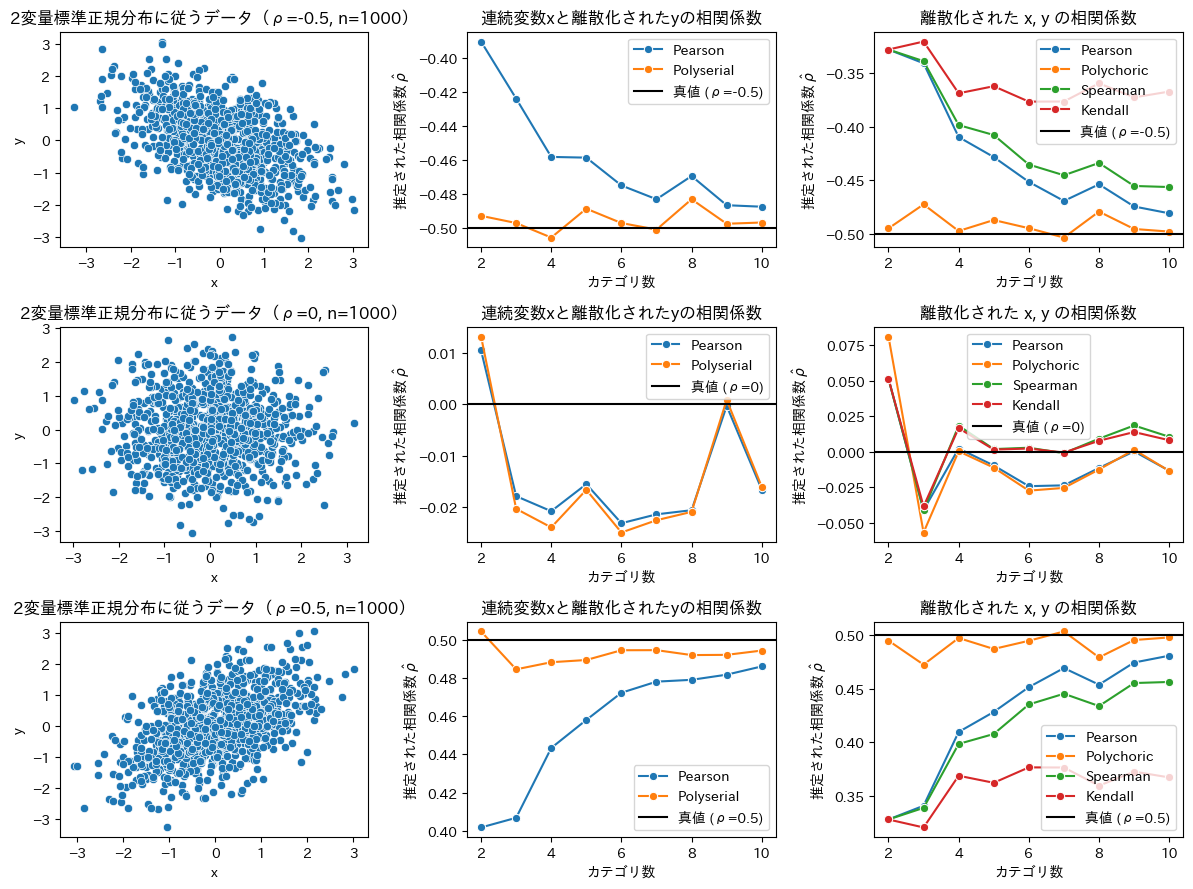

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_fontja
from scipy.stats import multivariate_normal, pearsonr, spearmanr, kendalltau
from ordinalcorr import polychoric, polyserial

def gen_bivariate_normal(rho=0.5, size=1000, seed=0):
    # 2変量標準正規分布によるデータ生成
    mean = [0, 0]
    std = [1, 1]
    cov = rho * std[0] * std[1]
    Cov = np.array([[std[0] ** 2, cov], [cov, std[1] ** 2]])
    X = multivariate_normal.rvs(mean=mean, cov=Cov, size=size, random_state=seed)
    df = pd.DataFrame(X, columns=["x", "y"])
    return df

def plot_data(ax, continuous_data, rho, n):
    sns.scatterplot(data=continuous_data, x="x", y="y", ax=ax)
    ax.set(title=f"2変量標準正規分布に従うデータ（ρ={rho}, n={n}）")

def plot_polyserial(ax, continuous_data, rho):
    # 離散化のカテゴリ数を変えつつ相関係数を算出
    results = []
    for k in range(2, 11):
        x = continuous_data["x"]
        y, _ = pd.cut(continuous_data["y"], bins=k).factorize(sort=True)
        results += [
            dict(method="Pearson", value=pearsonr(x, y).statistic, k=k),
            dict(method="Polyserial", value=polyserial(x, y), k=k),
        ]
    results = pd.DataFrame(results)

    # データをグラフにplot
    sns.lineplot(x="k", y="value", data=results, hue="method", marker="o", ax=ax)
    ax.axhline(rho, label=f"真値 (ρ={rho})", color="black")
    ax.set(
        xlabel="カテゴリ数",
        ylabel=r"推定された相関係数 $\hat{\rho}$",
        title="連続変数xと離散化されたyの相関係数"
    )
    ax.legend()

def plot_polychoric(ax, continuous_data, rho):
    # 離散化のカテゴリ数を変えつつ相関係数を算出
    results = []
    for k in range(2, 11):
        x, _ = pd.cut(continuous_data["x"], bins=k).factorize(sort=True)
        y, _ = pd.cut(continuous_data["y"], bins=k).factorize(sort=True)
        results += [
            dict(method="Pearson", value=pearsonr(x, y).statistic, k=k),
            dict(method="Polychoric", value=polychoric(x, y), k=k),
            dict(method="Spearman", value=spearmanr(x, y).statistic, k=k),
            dict(method="Kendall", value=kendalltau(x, y).statistic, k=k),
        ]
    results = pd.DataFrame(results)

    # データをグラフにplot
    sns.lineplot(x="k", y="value", data=results, hue="method", marker="o", ax=ax)
    ax.axhline(rho, label=f"真値 (ρ={rho})", color="black")
    ax.set(
        xlabel="カテゴリ数",
        ylabel=r"推定された相関係数 $\hat{\rho}$",
        title="離散化された x, y の相関係数"
    )
    ax.legend()

# 実験
n = 1000
fig, axes = plt.subplots(figsize=[12, 9], nrows=3, ncols=3, tight_layout=True)
rhos = [-0.5, 0, 0.5]
for i, rho in enumerate(rhos):
    continuous_data = gen_bivariate_normal(rho=rho, size=n)
    plot_data(axes[i, 0], continuous_data, rho, n)
    plot_polyserial(axes[i, 1], continuous_data, rho)
    plot_polychoric(axes[i, 2], continuous_data, rho)

こうした問題に対処するために、順序尺度同士の相関係数が考案されている。主に2つ

- **ポリコリック相関係数**（polychoric correlation coefficient）：順序尺度同士の相関係数
- **ポリシリアル相関係数**（polyserial correlation coefficient）：順序尺度と連続尺度の相関係数



順序尺度についての相関係数は他にも色々ある

:::{admonition} 順序尺度の相関係数
:class: info


- **ポリコリック相関係数（polychoric correlation coefficient、多分相関係数）**
    - 順序尺度 × 順序尺度の変数間の潜在的な連続正規変数に基づく相関係数（2変量正規分布仮定）
- **ポリシリアル相関係数（polyserial correlation coefficient、多分系列相関係数）**
    - 順序尺度 × 連続尺度の変数間の潜在変数モデルに基づく相関係数（順序側が閾値で2値化された連続変数と仮定）
- **テトラコリック相関係数（tetrachoric correlation coefficient、四分相関係数）** 
    - 2値変数 × 2値変数の相関。ただし両者は潜在連続変数をしきい値で2値化したものと仮定（2変量正規分布）
- **バイシリアル相関係数（biserial correlation coefficient、双列相関係数）**
    - 連続変数 × 人工的に2値化された変数の相関（連続データを2値に変換した前提）
- **ポイント・バイシリアル相関係数（point-biserial correlation coefficient、点双列相関係数）**
    - 連続変数 × 真のカテゴリとしての2値変数の相関（2値が自然なカテゴリであり、人工的でない場合）
- **スピアマンの順位相関係数（Spearman's rho）**
    - 順序尺度 × 順序尺度 あるいは 任意の変数を順位に置き換えて測る相関（順位ベースのピアソン相関）
- **ケンドールの順位相関係数（Kendall's tau）**
    - 順序尺度 × 順序尺度に対して使われる相関指標で、順位の一致/不一致ペア数に基づいて計算される

:::

:::{hint}
因子分析をする場合、「5値以上あれば積率相関係数でも誤差があまり大きくないため、連続尺度の変数のように積率相関係数にもとづいて相関を分析してもよい」という研究結果もある。

「1: 全くあてはまらない」「2: あまりあてはまらない」...「5: よくあてはまる」の5件法がよく使われる理由のひとつはこのため。

（[萩生田 & 繁桝 1996](https://www.jstage.jst.go.jp/article/jjpsy1926/67/1/67_1_1/_article/-char/ja/)）
:::


## 目次

:::{tableofcontents}
:::

## 参考文献

- 豊田秀樹（2012）『因子分析入門』、東京図書。
- [小杉考司（2013）順序尺度の相関係数（ポリコリック相関係数）について](http://kosugitti.sakura.ne.jp/wp/wp-content/uploads/2013/08/polynote.pdf)
- [萩生田伸子, & 繁桝算男. (1996). 順序付きカテゴリカルデータへの因子分析の適用に関するいくつかの注意点. 心理学研究, 67(1), 1-8.](https://www.jstage.jst.go.jp/article/jjpsy1926/67/1/67_1_1/_article/-char/ja/)
- [Rのpsychパッケージのマニュアル](https://personality-project.org/r/psych-manual.pdf#page=408.70) p.411あたりのtetrachoricのDetailsセクションの説明が詳しい